# Intro to project

TED is a nonprofit devoted to spreading ideas, usually in the form of short, powerful talks (18 minutes or less). TED began in 1984 as a conference where Technology, Entertainment and Design converged, and today covers almost all topics — from science to business to global issues — in more than 100 languages. Meanwhile, independently run TEDx events help share ideas in communities around the world. <br>

Our Mission: Spread ideas
TED is a global community, welcoming people from every discipline and culture who seek a deeper understanding of the world. We believe passionately in the power of ideas to change attitudes, lives and, ultimately, the world. On TED.com, we're building a clearinghouse of free knowledge from the world's most inspired thinkers — and a community of curious souls to engage with ideas and each other, both online and at TED and TEDx events around the world, all year long. <br>

Project: <br>
In line with TED's mission to foster a community of 'curious souls' to engage with ideas and each other, TED events are posted online (on ted.com and YouTube). TED viewers are able to comment on the videos offering their independent opinions, ideas, and insights. Evidence for educational psychology as well as online discussion forums indicate that posts that start or end with a question, and posts that are longer than 10 words are more likely to elicit replies. For this reason, to encourage global discourse, it may be in the platform's best interest to make relevant / relevant+positive comments more easily accessible and visible. Where positive, comments that contain questions will be given priority (i.e., displayed near the top). To achieve this, my capstone project will use tf_idf scores, doc2vec, and cosine similarities to identify relevant comments. As well, I will use Textblob to determine comment sentiment. Then using unsupervised k-means, I will label comments in one of 6 classes: <br>
* positive + relevant<br>
* positive + irrelevant<br>
* neutral + relevant<br>
* neutral + irrelevant<br>
* negative + relevant<br>
* negative + irrelevant<br>

I argue that comments that are positive and relevant should be given higher priority, while those that are negative and irrelevant should be given lower priority.

In [1]:
import json
import pandas as pd
import numpy as np
import gensim
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.corpus import stopwords
from textblob import TextBlob
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
json_talk = pd.read_json("/Users/cherylto/Dropbox/Ryerson Course/Capstone/Data/ted_talks-10-Sep-2012.json")

In [3]:
#This nifty function gets all the values from specific key pairs despite nesting :) :) 
def find(key, dictionary):
    for k, v in dictionary.items():
        if k == key:
            yield v
        elif isinstance(v, dict):
            for result in find(key, v):
                yield result
        elif isinstance(v, list):
            for d in v:
                for result in find(key, d):
                    yield result

In [4]:
lemmatizer = WordNetLemmatizer()
stopwords = set(stopwords.words('english'))
def preprocess(document):
    words = document.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(words)
    filtered_words = ' '.join([w for w in tokens if not w in stopwords])
    filtered_words = ''.join([i for i in filtered_words if not i.isdigit()])
    lemmas = lemmatizer.lemmatize(filtered_words)
    return ''.join(lemmas)

In [5]:
#gets comment and video id and puts it in a dataframe
_id = []
zipped_list = []
for i in range(len(json_talk['comments'])):   
    doc_id = json_talk['id'][i] #gets the ted_talk id
    _id.append(doc_id)
    zipped = ()
    text = []
    for j in range(len(json_talk['comments'][i])):
        txt = list(find('text', json_talk['comments'][i][j]))[0]   #this actually creates list of list of lists
        text.append(txt)
    zipped = (text, doc_id)
    zipped_list.append(zipped)
    
df = pd.DataFrame(zipped_list, columns = ['comments', '_id'])

In [6]:
#adding transcripts to the dataframe
df['transcripts'] = json_talk['transcript']

In [7]:
df.head()

,comments,_id,transcripts
0,[Doesn't gunfire produce visual illumination a...,062dd0f773cd5999a09714a371e1f8017163e2a1,The murder happened a little over 21 years ago...
1,[I would love to know how they solved the prob...,62f6479a5eca39725798b1ee300bd8d5de3a4ae3,"As a kid, I was fascinated with all things air..."
2,"[Actually, It is simple idea that we use solar...",b35c0cd294cd10748019833cafa625fc33487065,Good evening. We are in this wonderful open-ai...
3,"[I used to do this as a kid all the time, thou...",0fa6bca242ccb96697e8de570882c6b38746591a,"So, last month, the Encyclopaedia Britannica a..."
4,[Where is the video where this guy shows us th...,41db62481aeb978fd13f591755b596ff0616be70,"So a few weeks ago, a friend of mine gave this..."


In [8]:
from gensim import corpora, models, similarities

In [9]:
similarity = []
texts = []
for i in range(len(df)):
    documents = df.iloc[i]['comments']
    
    texts = [preprocess(document).split() for document in documents]
    #for i in documents:
        #prep1 = preprocess(i)
        #prep2 = [prep1.split()]
        #texts.extend(prep2)

    #print(texts)
    dictionary = corpora.Dictionary(texts)
    #print(dictionary)
    #print(dictionary.token2id) # to see the mapping between words and their ids
    
    #to convert tokenized documents to vectors
    #doc_vectors = dictionary.doc2bow(prep2.split())  #creates a sparse vector
    #print(doc_vectors)
    
    #builds the corpus
    corpus = [dictionary.doc2bow(text) for text in texts]
    #print(corpus)
    
    #Market Matrix Format
    corpora.MmCorpus.serialize('/tmp/corpus.mm', corpus)
    corpus = corpora.MmCorpus('/tmp/corpus.mm')
    print(corpus)
    
    tfidf=models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    #for doc in corpus_tfidf:
    #    print(doc)
    
    lsi = models.LsiModel(corpus, id2word=dictionary, num_topics = 10)
    query_doc = preprocess(df['transcripts'][i])
    vec_bow = dictionary.doc2bow(query_doc.split())
    vec_lsi = lsi[vec_bow]
    #print(vec_lsi)
    
    index = similarities.MatrixSimilarity(lsi[corpus])
    sims = index[vec_lsi]
    #sims_list = list(enumerate(sims))
    similarity.append(sims)
    #print(sorted(sims_list, key = lambda s: s[1], reverse = True))
    del dictionary
    

MmCorpus(7 documents, 121 features, 134 non-zero entries)
MmCorpus(43 documents, 551 features, 815 non-zero entries)
MmCorpus(32 documents, 638 features, 907 non-zero entries)
MmCorpus(45 documents, 549 features, 848 non-zero entries)
MmCorpus(43 documents, 723 features, 1031 non-zero entries)
MmCorpus(86 documents, 1536 features, 2784 non-zero entries)
MmCorpus(62 documents, 1008 features, 1649 non-zero entries)
MmCorpus(30 documents, 746 features, 1042 non-zero entries)
MmCorpus(62 documents, 1291 features, 2289 non-zero entries)
MmCorpus(85 documents, 1858 features, 3698 non-zero entries)
MmCorpus(100 documents, 884 features, 1601 non-zero entries)
MmCorpus(78 documents, 1153 features, 1856 non-zero entries)
MmCorpus(67 documents, 1023 features, 1613 non-zero entries)
MmCorpus(58 documents, 1237 features, 1926 non-zero entries)
MmCorpus(130 documents, 1480 features, 2950 non-zero entries)
MmCorpus(192 documents, 2247 features, 5281 non-zero entries)
MmCorpus(86 documents, 1401 featu

MmCorpus(59 documents, 1659 features, 3001 non-zero entries)
MmCorpus(105 documents, 1004 features, 1963 non-zero entries)
MmCorpus(25 documents, 449 features, 604 non-zero entries)
MmCorpus(95 documents, 1496 features, 2727 non-zero entries)
MmCorpus(56 documents, 560 features, 834 non-zero entries)
MmCorpus(44 documents, 286 features, 367 non-zero entries)
MmCorpus(49 documents, 1251 features, 1968 non-zero entries)
MmCorpus(35 documents, 718 features, 1029 non-zero entries)
MmCorpus(63 documents, 1223 features, 2054 non-zero entries)
MmCorpus(79 documents, 1379 features, 2593 non-zero entries)
MmCorpus(64 documents, 719 features, 1119 non-zero entries)
MmCorpus(163 documents, 2027 features, 4102 non-zero entries)
MmCorpus(80 documents, 1717 features, 3434 non-zero entries)
MmCorpus(34 documents, 615 features, 846 non-zero entries)
MmCorpus(22 documents, 509 features, 608 non-zero entries)
MmCorpus(106 documents, 1842 features, 3475 non-zero entries)
MmCorpus(64 documents, 1342 featu

MmCorpus(59 documents, 1307 features, 2275 non-zero entries)
MmCorpus(162 documents, 2715 features, 6273 non-zero entries)
MmCorpus(251 documents, 3995 features, 12875 non-zero entries)
MmCorpus(36 documents, 571 features, 784 non-zero entries)
MmCorpus(265 documents, 4313 features, 12927 non-zero entries)
MmCorpus(35 documents, 738 features, 1007 non-zero entries)
MmCorpus(35 documents, 459 features, 645 non-zero entries)
MmCorpus(55 documents, 1185 features, 2076 non-zero entries)
MmCorpus(31 documents, 307 features, 375 non-zero entries)
MmCorpus(38 documents, 636 features, 935 non-zero entries)
MmCorpus(75 documents, 664 features, 1066 non-zero entries)
MmCorpus(46 documents, 799 features, 1217 non-zero entries)
MmCorpus(99 documents, 2077 features, 4411 non-zero entries)
MmCorpus(27 documents, 709 features, 970 non-zero entries)
MmCorpus(120 documents, 2067 features, 4204 non-zero entries)
MmCorpus(66 documents, 446 features, 862 non-zero entries)
MmCorpus(20 documents, 710 featur

MmCorpus(501 documents, 4392 features, 14517 non-zero entries)
MmCorpus(46 documents, 840 features, 1348 non-zero entries)
MmCorpus(66 documents, 1012 features, 1765 non-zero entries)
MmCorpus(75 documents, 864 features, 1342 non-zero entries)
MmCorpus(30 documents, 350 features, 435 non-zero entries)
MmCorpus(109 documents, 1404 features, 2940 non-zero entries)
MmCorpus(16 documents, 377 features, 493 non-zero entries)
MmCorpus(154 documents, 1434 features, 3185 non-zero entries)
MmCorpus(21 documents, 169 features, 208 non-zero entries)
MmCorpus(78 documents, 591 features, 921 non-zero entries)
MmCorpus(19 documents, 425 features, 557 non-zero entries)
MmCorpus(80 documents, 1386 features, 2708 non-zero entries)
MmCorpus(63 documents, 1122 features, 1883 non-zero entries)
MmCorpus(81 documents, 1298 features, 2238 non-zero entries)
MmCorpus(148 documents, 2707 features, 5887 non-zero entries)
MmCorpus(172 documents, 3256 features, 7932 non-zero entries)
MmCorpus(232 documents, 2762 f

MmCorpus(40 documents, 917 features, 1387 non-zero entries)
MmCorpus(32 documents, 561 features, 775 non-zero entries)
MmCorpus(31 documents, 702 features, 1018 non-zero entries)
MmCorpus(44 documents, 881 features, 1314 non-zero entries)
MmCorpus(194 documents, 2801 features, 6867 non-zero entries)
MmCorpus(140 documents, 2062 features, 4428 non-zero entries)
MmCorpus(63 documents, 1571 features, 2828 non-zero entries)
MmCorpus(183 documents, 3079 features, 8215 non-zero entries)
MmCorpus(26 documents, 460 features, 605 non-zero entries)
MmCorpus(46 documents, 932 features, 1429 non-zero entries)
MmCorpus(100 documents, 1529 features, 2795 non-zero entries)
MmCorpus(162 documents, 2828 features, 6301 non-zero entries)
MmCorpus(26 documents, 224 features, 285 non-zero entries)
MmCorpus(717 documents, 4461 features, 16902 non-zero entries)
MmCorpus(75 documents, 1686 features, 3022 non-zero entries)
MmCorpus(31 documents, 623 features, 890 non-zero entries)
MmCorpus(41 documents, 804 fe

MmCorpus(94 documents, 1530 features, 2955 non-zero entries)
MmCorpus(95 documents, 877 features, 1579 non-zero entries)
MmCorpus(207 documents, 3600 features, 9391 non-zero entries)
MmCorpus(155 documents, 2210 features, 4867 non-zero entries)
MmCorpus(80 documents, 1024 features, 1794 non-zero entries)
MmCorpus(66 documents, 788 features, 1244 non-zero entries)
MmCorpus(56 documents, 1396 features, 2377 non-zero entries)
MmCorpus(78 documents, 1421 features, 2555 non-zero entries)
MmCorpus(118 documents, 1974 features, 4263 non-zero entries)
MmCorpus(221 documents, 3400 features, 9960 non-zero entries)
MmCorpus(64 documents, 1603 features, 2780 non-zero entries)
MmCorpus(25 documents, 548 features, 690 non-zero entries)
MmCorpus(103 documents, 1233 features, 2290 non-zero entries)
MmCorpus(132 documents, 1839 features, 3894 non-zero entries)
MmCorpus(80 documents, 1213 features, 2045 non-zero entries)
MmCorpus(54 documents, 1073 features, 1771 non-zero entries)
MmCorpus(121 documents

MmCorpus(339 documents, 5492 features, 17347 non-zero entries)
MmCorpus(25 documents, 507 features, 720 non-zero entries)
MmCorpus(59 documents, 1035 features, 1671 non-zero entries)
MmCorpus(76 documents, 2023 features, 3974 non-zero entries)
MmCorpus(40 documents, 886 features, 1246 non-zero entries)
MmCorpus(38 documents, 730 features, 1042 non-zero entries)
MmCorpus(45 documents, 474 features, 616 non-zero entries)
MmCorpus(139 documents, 2431 features, 5472 non-zero entries)
MmCorpus(68 documents, 466 features, 687 non-zero entries)
MmCorpus(87 documents, 1629 features, 3070 non-zero entries)
MmCorpus(133 documents, 2226 features, 5739 non-zero entries)
MmCorpus(107 documents, 1872 features, 3611 non-zero entries)
MmCorpus(35 documents, 808 features, 1238 non-zero entries)
MmCorpus(26 documents, 579 features, 787 non-zero entries)
MmCorpus(249 documents, 4335 features, 12877 non-zero entries)
MmCorpus(44 documents, 788 features, 1114 non-zero entries)
MmCorpus(24 documents, 533 fe

MmCorpus(56 documents, 1765 features, 2681 non-zero entries)
MmCorpus(42 documents, 711 features, 1067 non-zero entries)
MmCorpus(160 documents, 2172 features, 4806 non-zero entries)
MmCorpus(225 documents, 1156 features, 2274 non-zero entries)
MmCorpus(235 documents, 4899 features, 14962 non-zero entries)
MmCorpus(34 documents, 605 features, 834 non-zero entries)
MmCorpus(162 documents, 2765 features, 6308 non-zero entries)
MmCorpus(56 documents, 945 features, 1473 non-zero entries)
MmCorpus(44 documents, 1022 features, 1482 non-zero entries)
MmCorpus(117 documents, 2685 features, 5991 non-zero entries)
MmCorpus(38 documents, 729 features, 1055 non-zero entries)
MmCorpus(84 documents, 1360 features, 2418 non-zero entries)
MmCorpus(65 documents, 1313 features, 2392 non-zero entries)
MmCorpus(60 documents, 855 features, 1345 non-zero entries)
MmCorpus(79 documents, 1167 features, 1995 non-zero entries)
MmCorpus(95 documents, 2032 features, 4084 non-zero entries)
MmCorpus(83 documents, 1

MmCorpus(174 documents, 3443 features, 8310 non-zero entries)
MmCorpus(262 documents, 4697 features, 13398 non-zero entries)
MmCorpus(198 documents, 3669 features, 10369 non-zero entries)
MmCorpus(61 documents, 951 features, 1489 non-zero entries)
MmCorpus(120 documents, 1580 features, 3166 non-zero entries)
MmCorpus(46 documents, 894 features, 1340 non-zero entries)
MmCorpus(60 documents, 629 features, 951 non-zero entries)
MmCorpus(125 documents, 2243 features, 4834 non-zero entries)
MmCorpus(55 documents, 1110 features, 1954 non-zero entries)
MmCorpus(180 documents, 3207 features, 7600 non-zero entries)
MmCorpus(81 documents, 733 features, 1256 non-zero entries)
MmCorpus(59 documents, 747 features, 1277 non-zero entries)
MmCorpus(90 documents, 839 features, 1684 non-zero entries)
MmCorpus(82 documents, 1247 features, 2207 non-zero entries)
MmCorpus(243 documents, 3655 features, 11220 non-zero entries)
MmCorpus(79 documents, 789 features, 1296 non-zero entries)
MmCorpus(68 documents,

In [10]:
len(similarity)

1203

In [11]:
import sys
all_data = pd.DataFrame()
for i in range(len(json_talk['comments'])):
    title = json_talk['id'][i]    
    
    for j in range(len(json_talk['comments'][i])):
        date, comments = list(find('date', json_talk['comments'][i][j]))[0], list(find('text', json_talk['comments'][i][j]))[0]
        #first_comments.append(comments)
        data = pd.DataFrame([date, comments]).T
        titles = pd.DataFrame(title, index=range(len(data)), columns = range(1))
        data = pd.concat((titles, data), axis = 1)
        all_data=pd.concat((all_data, data), axis = 0)
        sys.stdout.write('%04d/%d\r' % (i+1, len(json_talk)))
        sys.stdout.flush()


In [12]:
all_data.reset_index(inplace = True, drop = True)
all_data.columns = [['title_index', 'date', 'comment']]
print(len(all_data))

117516


In [13]:
flattened = []
for i in similarity:
    for j in i:
        flattened.append(j)
        
print(len(flattened))

117516


In [14]:
all_data['similarity'] = flattened

In [15]:
all_data.iloc[7:15] #some dates come with ":"

,title_index,date,comment,similarity
7,62f6479a5eca39725798b1ee300bd8d5de3a4ae3,Jul 25 2012:,I would love to know how they solved the probl...,0.400901
8,62f6479a5eca39725798b1ee300bd8d5de3a4ae3,Jul 25 2012:,How is this different from Celestia ( http://e...,0.276638
9,62f6479a5eca39725798b1ee300bd8d5de3a4ae3,Jul 25 2012:,"Good software, but this is a wrong model of th...",0.476771
10,62f6479a5eca39725798b1ee300bd8d5de3a4ae3,Jul 11 2012:,"So this is a great talk, no doubt. \nHowever. ...",0.371817
11,62f6479a5eca39725798b1ee300bd8d5de3a4ae3,Jul 8 2012:,Has anyone ever used Celestia? This open sourc...,0.487658
12,62f6479a5eca39725798b1ee300bd8d5de3a4ae3,Jul 8 2012:,My favourite app on my iphone is solar walk i ...,0.724350
13,62f6479a5eca39725798b1ee300bd8d5de3a4ae3,Jul 5 2012:,The universe is so fascinating. It's so cool ...,0.575121
14,62f6479a5eca39725798b1ee300bd8d5de3a4ae3,Jul 4 2012:,love the ideas that are expressed here,0.288496


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a5534fe48>]],
      dtype=object)

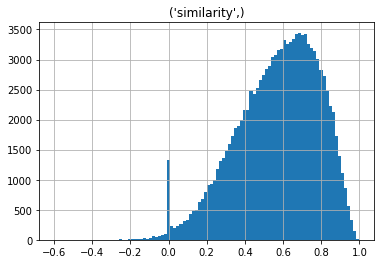

In [16]:
all_data['similarity'].hist(bins = 100)

In [17]:
all_data['similarity'].mean() #much better than tfidf with scikitlearn!

similarity    0.570058
dtype: float64

In [18]:
all_data.iloc[0]['comment'][0]

"Doesn't gunfire produce visual illumination as well? Couldn't the gunflash light up the person's face for the instant it would take to imprint that image indelibly. \n Hmm?"

In [19]:
senti = []
for i in range(len(all_data)):
    c = all_data.iloc[i]['comment'][0]
    b = TextBlob(c)
    senti.append(b.sentiment.polarity)
    

In [20]:
print(len(senti))

117516


In [21]:
all_data['sentiment'] = senti

In [22]:
all_data.head()

,title_index,date,comment,similarity,sentiment
0,062dd0f773cd5999a09714a371e1f8017163e2a1,Sep 10 2012,Doesn't gunfire produce visual illumination as...,0.484312,0.133333
1,062dd0f773cd5999a09714a371e1f8017163e2a1,Sep 10 2012,"He's wrong, the first video coverage of the wo...",0.411014,0.138961
2,062dd0f773cd5999a09714a371e1f8017163e2a1,Sep 10 2012,My question: the court system of America vs Eu...,0.290572,0.500000
3,062dd0f773cd5999a09714a371e1f8017163e2a1,Sep 10 2012,"Under normal circumstances, the human eye has ...",0.515269,0.156250
4,062dd0f773cd5999a09714a371e1f8017163e2a1,Sep 10 2012,I recall a lot of science in the O.J. Simpson ...,0.311558,0.000000


In [23]:
from sklearn.cluster import KMeans

In [24]:
X = np.array(all_data[['sentiment', 'similarity']])

In [25]:
kmeans = KMeans(n_clusters = 6, random_state = 0).fit(X)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print(centroids)
print(labels)

[[ 0.12214599  0.77445709]
 [ 0.07556909  0.21968463]
 [-0.07914577  0.55903181]
 [ 0.23040061  0.48919777]
 [ 0.43092938  0.71025895]
 [ 0.71068609  0.38399685]]
[3 3 5 ... 0 3 4]


In [26]:
all_data['labels'] = labels

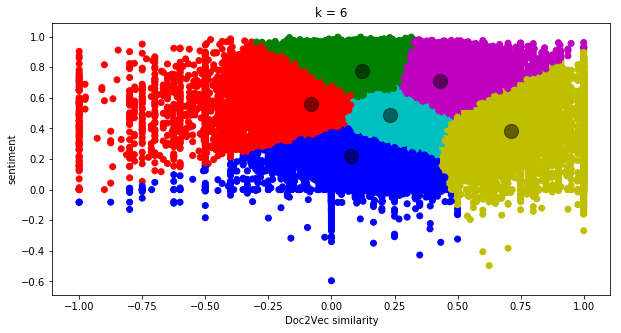

In [27]:
plt.figure(figsize = (10,5))
label_c = {0: 'g', 1: 'b', 2: 'r', 3: 'c', 4: 'm', 5: 'y'}
label_color = [label_c[l] for l in labels]
plt.scatter(X[:,0], X[:,1], c=label_color)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5)
plt.xlabel("Doc2Vec similarity")
plt.ylabel("sentiment")
plt.title("k = 6")
plt.show()

[[0.06607788 0.36074544]
 [0.57053727 0.4982755 ]
 [0.1418724  0.7262425 ]]
[0 0 1 ... 2 0 2]


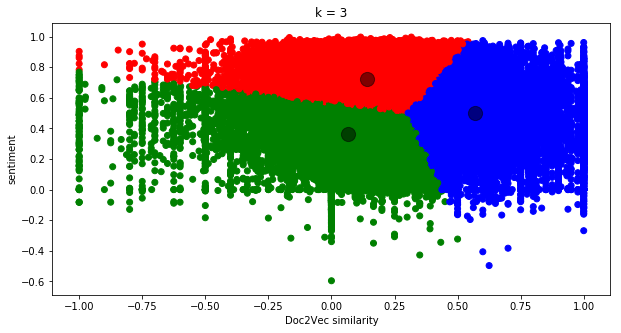

In [28]:
kmeans = KMeans(n_clusters = 3, random_state = 0).fit(X)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print(centroids)
print(labels)

plt.figure(figsize = (10,5))
label_c = {0: 'g', 1: 'b', 2: 'r', 3: 'c', 4: 'm', 5: 'y'}
label_color = [label_c[l] for l in labels]
plt.scatter(X[:,0], X[:,1], c=label_color)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5)
plt.xlabel("Doc2Vec similarity")
plt.ylabel("sentiment")
plt.title("k = 3")
plt.show()

Text(0.5,1,'The Elbow Method showing the optimal k')

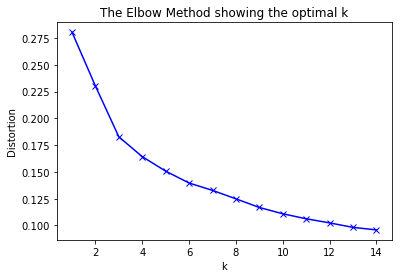

In [30]:
from scipy.spatial.distance import cdist
# k means determine k
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

Using the elbow method, it looks like there are 3 clusters. For the purpose of this study, because most comments have sentiment scores above 0, there is not much meaning to separating the lower similarity class into positive an negative. From this point on, I will use similarity score to determine as the main factor for prioritizing comments.

In [ ]:
#all_data.to_csv('all_data_doc2vec.csv')